<h1><center>Semantic Networks of Social Media Data</center></h1>

In [ ]:

import re
import tweepy

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import CountVectorizer
from dateutil import parser


# Scrape Tweets

In [ ]:


def initAPI():
    CONSUMER_KEY='XXXXX'
    CONSUMER_SECRET='XXXXX'
    ACCESS_TOKEN='XXXXX'
    ACCESS_SECRET='XXXXX'

    auth = tweepy.OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN,ACCESS_SECRET)

    return auth

def format_tweets(alltweets):
    """ format tweets to a list, keeping retweets """
    handle = alltweets[0]['user']['screen_name'] # twitter handle of current user
    # format created date as timestamp
    to_time = lambda x: parser.parse(x).strftime('%Y-%m-%d %H:%M:%S')

    lst = []

    for tweet in alltweets:
        try:
            tweet = tweet["retweeted_status"]
        except KeyError:
            pass

        lst.extend([[tweet['id'], to_time(tweet['created_at']), handle, tweet['full_text']]])

    return lst

def get_all_tweets(user_names):
    """ scrape the most recent tweets for given accounts. If it's a retweet, grab full text 
    from the original tweet. Return all tweets as a df """
    # initialize connection with json parser api to automatically output json dicts
    auth = initAPI()
    api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

    # holds all tweets of all users
    all_data = []

    for user_name in user_names:
        # holds all most recent tweets of current user
        alltweets = []
        # get first 200 extended tweets from current user
        new_tweets = api.user_timeline(screen_name = user_name, count=200, tweet_mode = "extended")
        alltweets.extend(new_tweets)

        # store tweet id of the last tweet pulled -1 to set new data scraping starting point
        oldest = alltweets[-1]['id'] - 1

        handle = alltweets[0]['user']['screen_name'] # twitter handle of current user
        print(f"Grabbing tweets from {handle}...")

        #keep grabbing tweets until there are none left (limit of 3250/user reached)
        while len(new_tweets) > 0:
            # pull next 200 tweets up to the tweet id of the last tweet of previous batch
            new_tweets = api.user_timeline(screen_name = user_name, count=200, tweet_mode ="extended", max_id=oldest)

            #save most recent tweets
            alltweets.extend(new_tweets)
            #update the max. tweet id for new starting point
            oldest = alltweets[-1]['id'] - 1

            if len(alltweets)%500 == 0:
                print(f"...{len(alltweets)} tweets pulled so far")

        print(f"{len(alltweets)} total tweets pulled from {handle}\n")

        data = format_tweets(alltweets)
        all_data.extend(data)

    df = pd.DataFrame(all_data, columns = ['tweet id', 'created at', 'screen name', 'full text'])
    return df



# Build Semantic Network

In [ ]:


def subdf(df, term):
    """ get a subset of tweets """
    sens = []
    for i in df.index:
        sen = df['full text'][i]

        if term in sen.lower():
            sens.extend([i])

    return df.loc[sens]

def clean_tweet(x):
    """ clean the tweets to remove accounts and links """ 

    # ignore irrelevant frequent words
    stop_words = ['says','like','said','tweet','tweeted']
    # make regex for components to clean from strings
    regex = "(@([A-Za-z0-9._-]+))|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([()!?])|(\[.*?\])|(#[A-Za-z0-9_]+)"
    # remove non-alphanumeric chars, punctuation, hashtags/mentions, and links then split into list
    clean=' '.join(re.sub(regex," ",x).split())
    # remove digits
    clean = re.sub(r'\d+', '', clean)
    # only keep non-stop words
    clean = [w for w in clean if w not in stop_words]
    # join words back together into a sentence
    clean = ''.join(word for word in clean)
    return clean

def vec(x):
    """ vectorizer to get the desired features and adj list """

    vectorizer = CountVectorizer(ngram_range=(1,1), min_df=2, stop_words="english", max_features=50) # default unigram model
    X = vectorizer.fit_transform(x)
    feature_names = vectorizer.get_feature_names_out()
    return X, feature_names

def cov_mat(X, threshold=1):
    """ get the feature to feature co-occurrence matrix 

    :param int threshold: threshold to reduce the density of the network

    :returns: covariance matrix
    """
    co = (X.T * X)              # co-occurrence matrix in sparse csr format
    co.setdiag(0)               # sometimes you want to fill same word cooccurence to 0

    co_matrix = np.where(co.todense()>threshold, 1, 0)
    return co_matrix

def build_semantic_network(x):
    """ build the semantic network graph 
    - use the dichotomized cooccurrence matrix to build the network
    - make node size proportional to the eigenvector centrality of words
    """

    df = pd.Series(list(x))
   # get features and adjacency list
    X, feats = vec(df)
    # get feature to feature co-occurrence matrix
    co_matrix = cov_mat(X)

    # Build a network out of this co-occurrence matrix
    G = nx.from_numpy_matrix(co_matrix, create_using=nx.Graph()) # creating from adjacency matrix
    node_name = dict(zip(range(0,len(list(G.nodes()))), feats))
    G = nx.relabel_nodes(G, node_name)
    return G

def show_semantic_network(G, title):
    """ show the network graph """

    # Take a look
    figure(figsize=(20,20), dpi=100)

    # node size proportional to eigenvector centrality of words
    node_size= [x*1000 for x in nx.eigenvector_centrality(G).values()]

    # choose a layout function
    pos=nx.kamada_kawai_layout(G)

    # edge color
    edge_color='0.8'

    nx.drawing.nx_pylab.draw_networkx(G,
                                      node_size=node_size,
                                      node_color = "pink",
                                      pos=pos,
                                      edge_color=edge_color,
                                      with_labels=True,
                                     font_size=12)
    plt.title(title)
    plt.axis("off")
    plt.show()



In [ ]:

# we use some examples of news outlets in this study:
# https://www.researchgate.net/profile/Matthew-Miles-2/publication/357193810_Does_the_Ideology_of_the_Newsroom_Affect_the_Provision_of_Media_Slant/links/62ea8ddf88b83e7320a67270/Does-the-Ideology-of-the-Newsroom-Affect-the-Provision-of-Media-Slant.pdf
# scrape the tweets for the specified accounts and compile a corpus
m1=['foxnews','dcexaminer','breitbartnews']
m1_corpus=get_all_tweets(m1)
# title for semantic nwk graph
t1 = "The  Semantic Network for Mentions of [ChatGPT] by Fox News, Breitbart, and the Washington Examiner on Twitter"

m2=['cnn','nytimes','msnbc']
m2_corpus=get_all_tweets(m2)
t2 = "The  Semantic Network for Mentions of [ChatGPT] by CNN, MSNBC, and The NY Times on Twitter"

# get a subset of tweets
term = "chatgpt"
df1, df2 = subdf(m1_corpus, term), subdf(m2_corpus, term)

# clean the tweets
df1["cleaned_tweet"]=df1.iloc[:,3].apply(clean_tweet)
df2["cleaned_tweet"]=df2.iloc[:,3].apply(clean_tweet)


# Show Final Networks

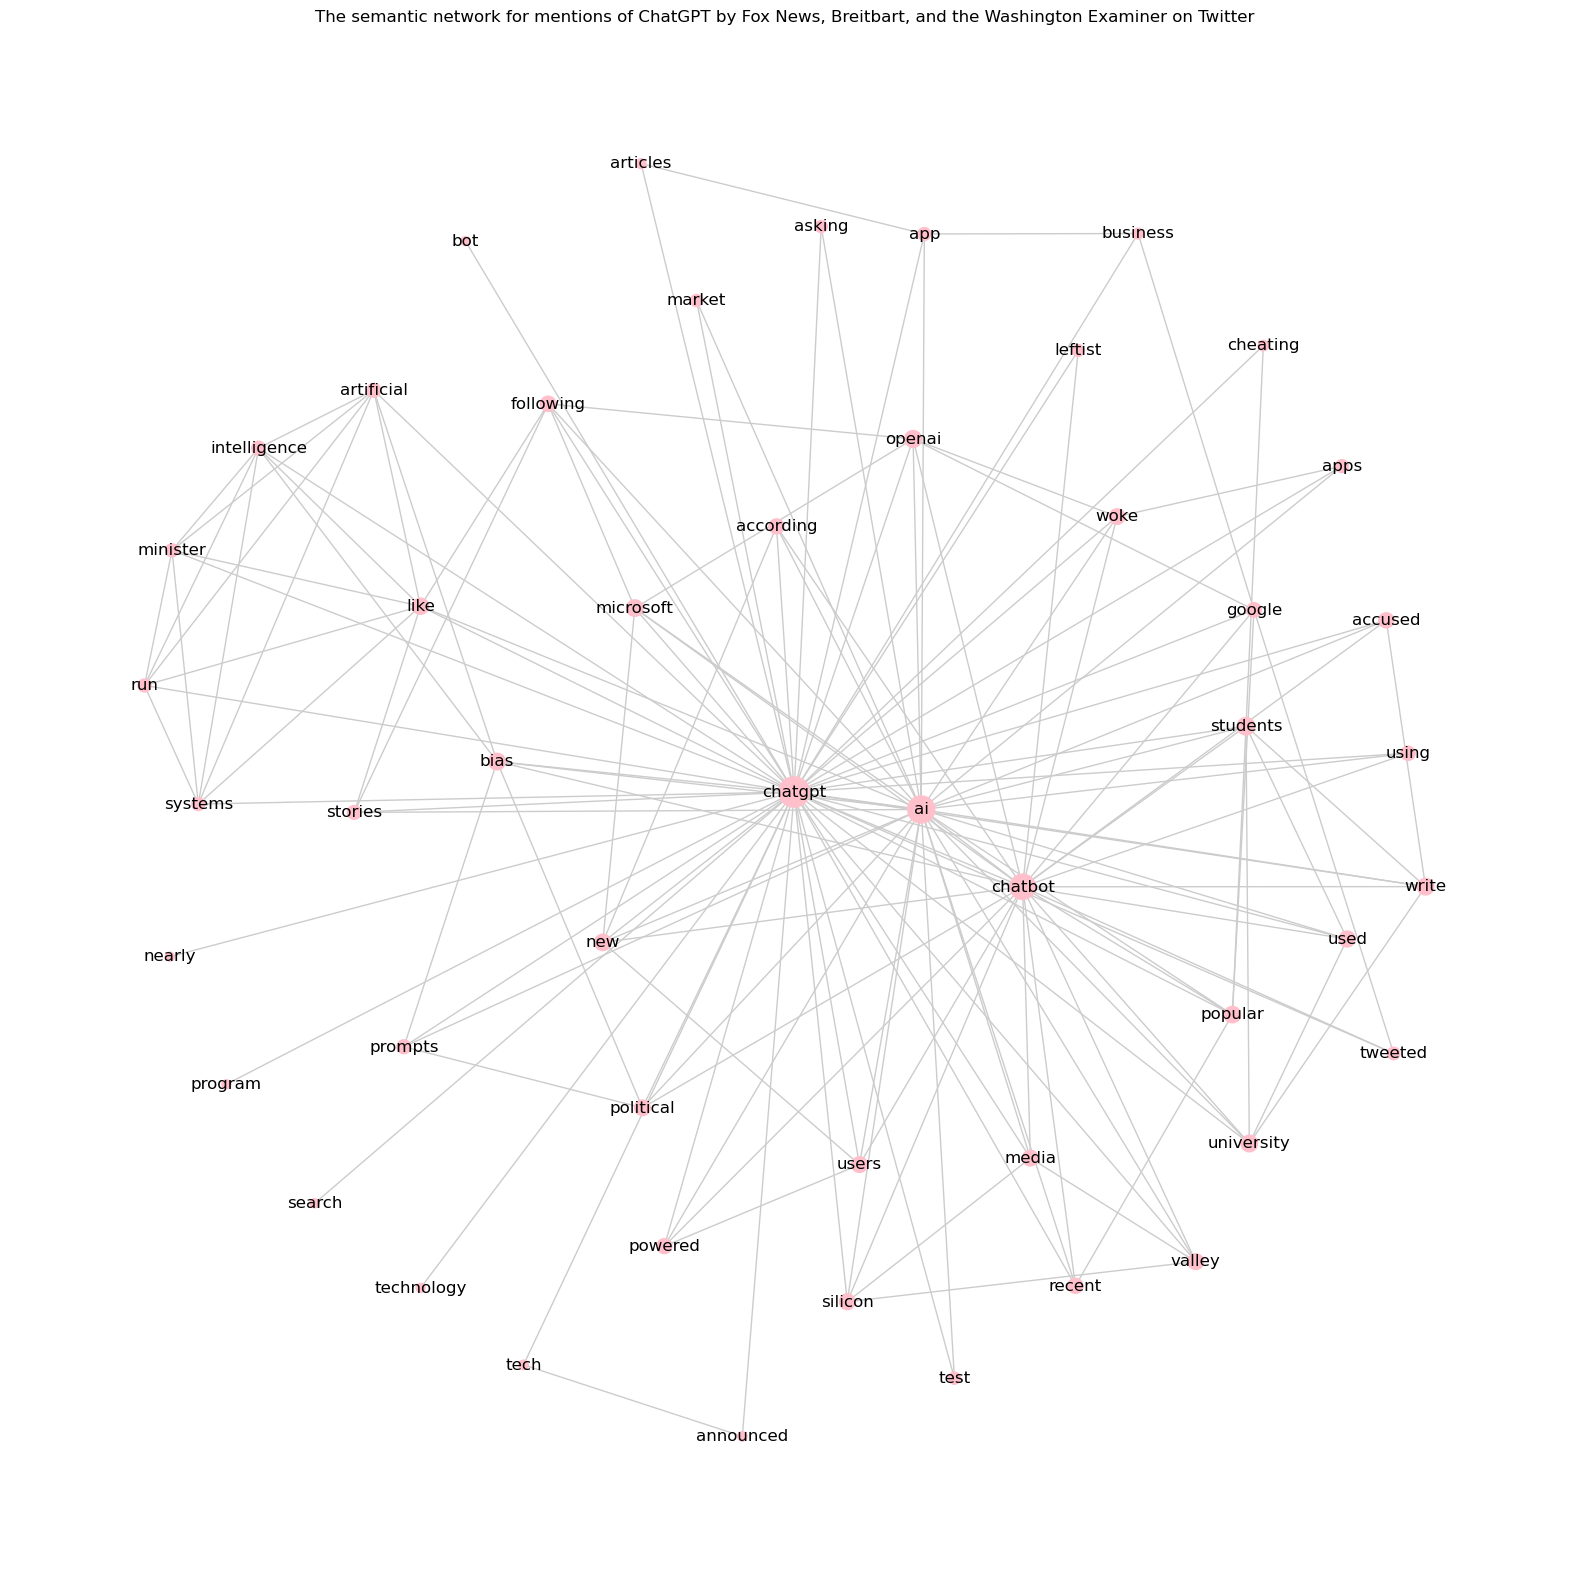

In [ ]:
# show network for corpus1
G1 = build_semantic_network(set(df1["cleaned_tweet"]))
show_semantic_network(G1, t1)

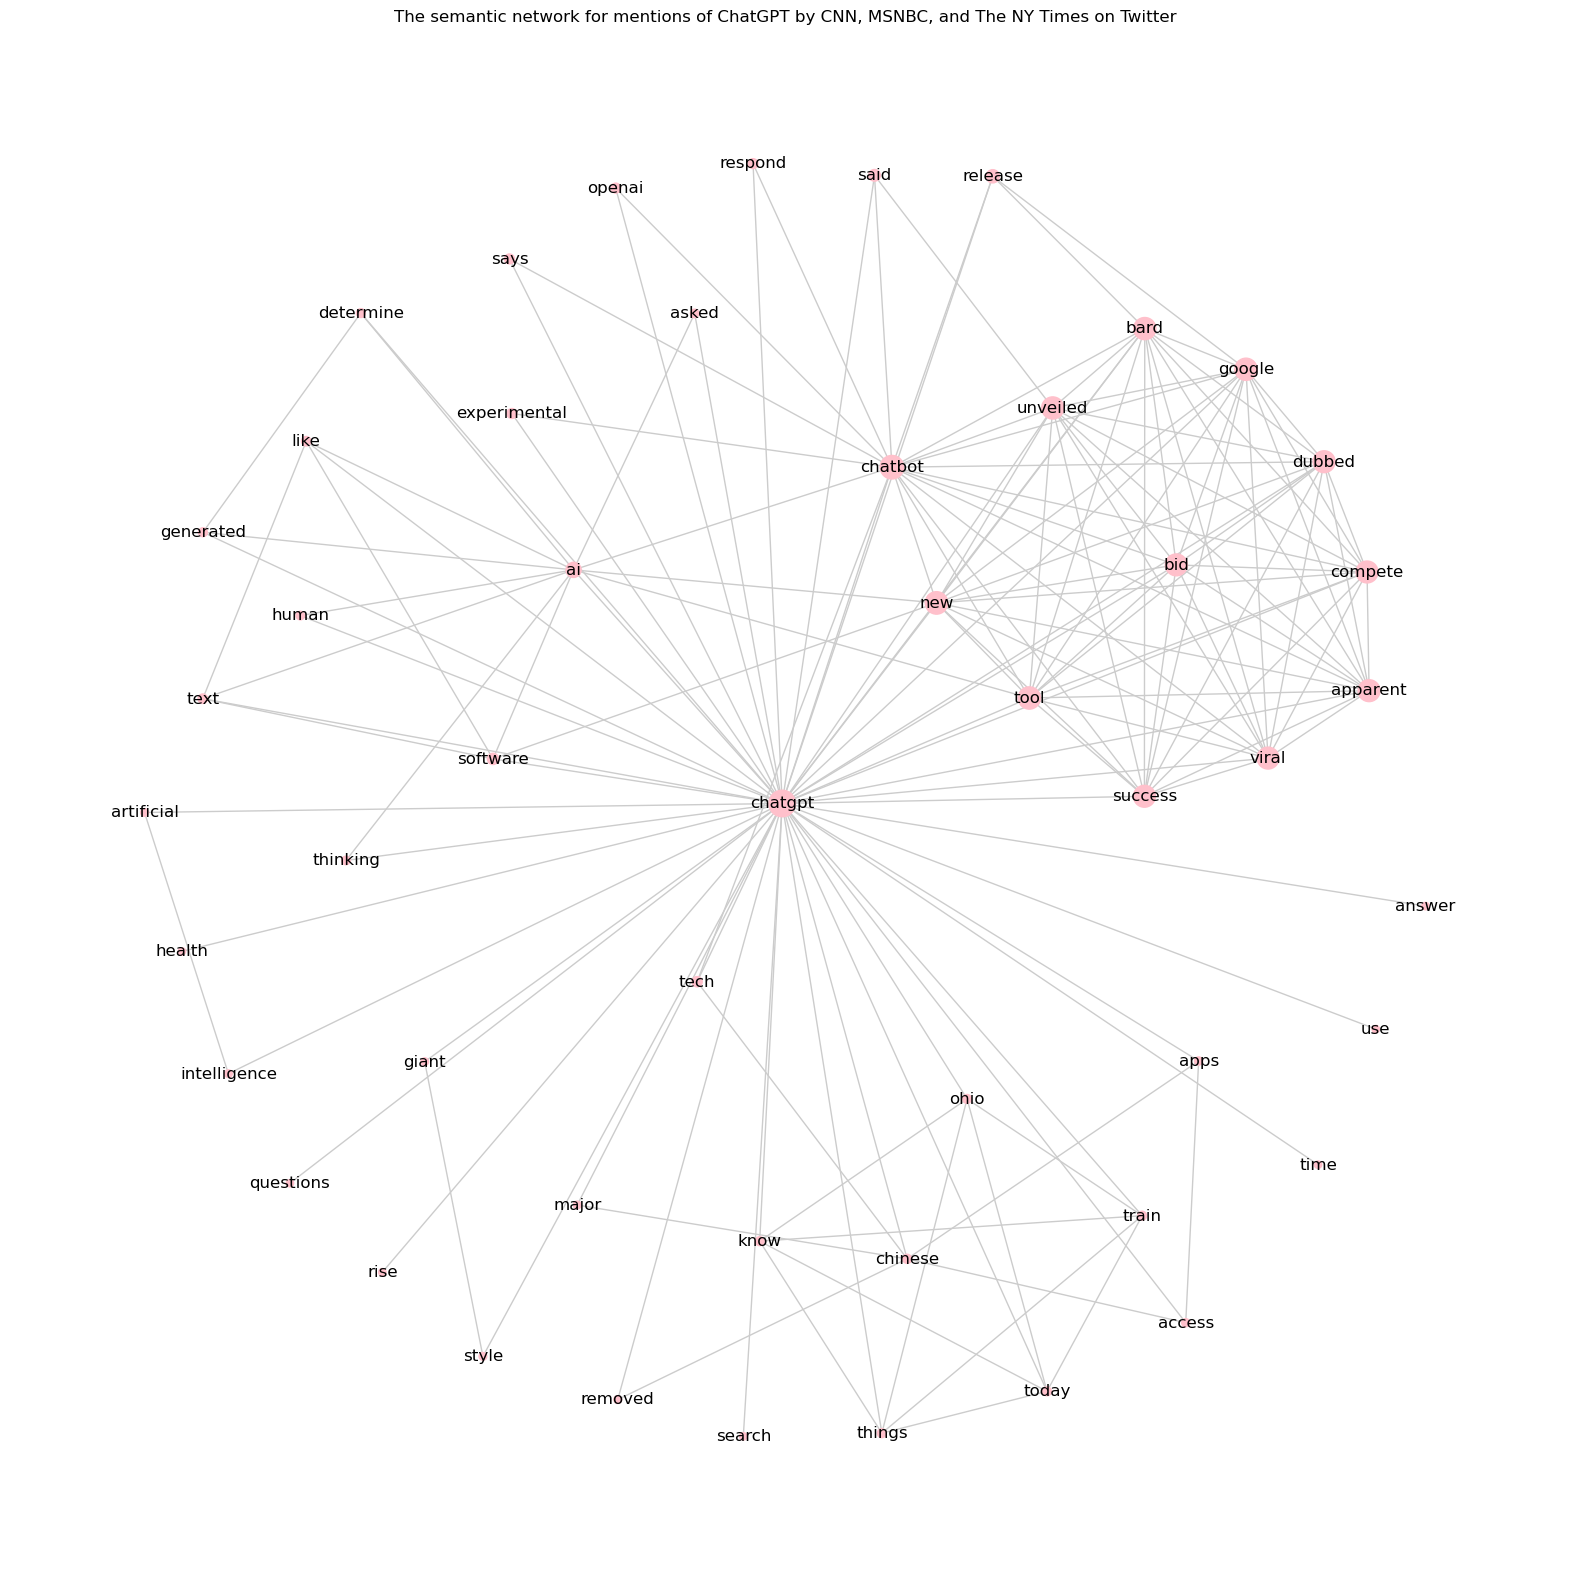

In [ ]:
# show network for corpus 2
G2 = build_semantic_network(set(df2["cleaned_tweet"]))
show_semantic_network(G2, t2)

# Analysis
* Based on your visualization, and the calculation of words' eigenvector centrality, briefly explain your observations


The networks show a visualization of the most popular terms used in tweets by three news networks using the term 'chatgpt', using two sets of users with opposing views.

Eigenvector centrality was used to scale the size of the nodes for each term, representing the scale of term frequency in comparision to the rest of the nodes in the network. This is similar to how eigenvalues and eigenvectors are used in principal component analysis (PCA), where eigenvalues represent the total amount of the variance explained by a given feature. In the semantic network, the node size shows how much influence each term has on the variance of all the terms in all tweets by all users.

For example, 'chatgpt' and 'chatbot' are the largest nodes in both networks. Since 'chatgpt' was the search keyword, it is guaranteed to be in every tweet, and should be the largest. It is also at the center of the web, since it is in 100% of the tweets, and has the largest influence over the variance of the entire cluster of tweets centered around 'chatgpt'. This also shows how nodes with larger magnitude eigenvectors will have more large nodes connected to them. Words that are more frequent are more likely to be used with other high frequency words, especially if they are more correlated such as 'chatgpt' and 'chatbot'. Since ChatGPT is a chatbot-style AI, it is unsuprising it is also found in a majority of the tweets and also has a large eigenvector.